In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.platform import gfile
import pandas as pd
from sklearn.metrics import confusion_matrix

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def load_graph(sess, model_file_name, node_mapping={}):
    with gfile.GFile(model_file_name, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, node_mapping)
with tf.Session() as sess:
    # Create a placeholder for the input
    input_node = tf.placeholder(tf.float32, shape = [None, 224, 224, 3], name='Placeholder')
    graph_def = load_graph(sess=sess,
                           model_file_name='weights-floatingpoint-224x224-fixval-best/constantgraph.pb',
                           node_mapping={'Placeholder': input_node})
# Get the node for output
output_node = tf.get_default_graph().get_tensor_by_name("import/classifier/model_1/classifier_output/Softmax:0")

In [4]:
import numpy as np
with tf.Session() as sess:
    y = sess.run(output_node, feed_dict={input_node: np.zeros((2, 224, 224, 3))})
print(y)

[[0.00170123 0.9982988 ]
 [0.00170123 0.9982988 ]]


In [5]:
def normalize_and_rgb(images): 
    import numpy as np
    #normalize image to 0-255 per image.
    image_sum = 1/np.sum(np.sum(images,axis=1),axis=-1)
    given_axis = 0
    # Create an array which would be used to reshape 1D array, b to have 
    # singleton dimensions except for the given axis where we would put -1 
    # signifying to use the entire length of elements along that axis  
    dim_array = np.ones((1,images.ndim),int).ravel()
    dim_array[given_axis] = -1
    # Reshape b with dim_array and perform elementwise multiplication with 
    # broadcasting along the singleton dimensions for the final output
    image_sum_reshaped = image_sum.reshape(dim_array)
    images = images*image_sum_reshaped*255

    # make it rgb by duplicating 3 channels.
    images = np.stack([images, images, images],axis=-1)
    
    return images

In [6]:
def count_events(train_files):
    import tables
    n_events = 0
    for train_file in train_files:
        f = tables.open_file(train_file, 'r')
        n_events += f.root.label.shape[0]
        f.close()
    return n_events

In [7]:
def chunks(files, chunksize, max_q_size=4, shuffle=True): 
    """Yield successive n-sized chunks from a and b.""" 
    import tables
    import numpy as np
    for train_file in files: 
        f = tables.open_file(train_file, 'r') 
        nrows = f.root.label.nrows
        for istart in range(0,nrows,max_q_size*chunksize):  
            a = np.array(f.root.img_pt[istart:istart+max_q_size*chunksize]) # Images 
            b = np.array(f.root.label[istart:istart+max_q_size*chunksize]) # Labels 
            if shuffle: 
                c = np.c_[a.reshape(len(a), -1), b.reshape(len(b), -1)] # shuffle within queue size
                np.random.shuffle(c)
                test_images = c[:, :a.size//len(a)].reshape(a.shape)
                test_labels = c[:, a.size//len(a):].reshape(b.shape)
            else:
                test_images = a
                test_labels = b
            for jstart in range(0,len(test_labels),chunksize): 
                yield normalize_and_rgb(test_images[jstart:jstart+chunksize].copy()),test_labels[jstart:jstart+chunksize].copy(), len(test_labels[jstart:jstart+chunksize].copy())  
        f.close()

In [8]:
def test_model(preds, in_images, test_files, chunk_size=64, shuffle=True):
    """Test the model"""
    import tensorflow.compat.v1 as tf
    tf.disable_v2_behavior()
    from keras import backend as K
    from keras.objectives import binary_crossentropy 
    import numpy as np
    from keras.metrics import categorical_accuracy
    from tqdm import tqdm
    
    in_labels = tf.placeholder(tf.float32, shape=(None, 2))
    
    cross_entropy = tf.reduce_mean(binary_crossentropy(in_labels, preds))
    accuracy = tf.reduce_mean(categorical_accuracy(in_labels, preds))
    auc = tf.metrics.auc(tf.cast(in_labels, tf.bool), preds)
   
    n_test_events = count_events(test_files)
    chunk_num = int(n_test_events/chunk_size)+1
    preds_all = []
    label_all = []
    
    sess = tf.Session()
    sess.run(tf.local_variables_initializer())
    
    avg_accuracy = 0
    avg_auc = 0
    avg_test_loss = 0
    is_training = tf.get_default_graph().get_tensor_by_name('import/is_training:0')
    n_current_events = 0
    for img_chunk, label_chunk, real_chunk_size in chunks(test_files, chunk_size, shuffle=shuffle):
        test_loss, accuracy_result, auc_result, preds_result = sess.run([cross_entropy, accuracy, auc, preds],
                        feed_dict={in_images: img_chunk,
                                   in_labels: label_chunk,
                                   K.learning_phase(): 0,
                                   is_training: False})
        avg_test_loss += test_loss * real_chunk_size / n_test_events
        avg_accuracy += accuracy_result * real_chunk_size / n_test_events
        avg_auc += auc_result[0]  * real_chunk_size / n_test_events 
        preds_all.extend(preds_result)
        label_all.extend(label_chunk)
        n_current_events += real_chunk_size
    
    return avg_test_loss, avg_accuracy, avg_auc, np.asarray(preds_all).reshape(n_test_events,2), np.asarray(label_all).reshape(n_test_events,2)

In [9]:
avg_test_loss, avg_accuracy, avg_auc, y_pred, y_real = test_model(output_node, input_node, ['img224_all/converted/rotation_224_v1/test_file_0.h5'])

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Using TensorFlow backend.


In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.pyplot as plt

In [13]:
def makeRoc(y_real, y_pred, labels, output_dir=os.curdir):
    df = pd.DataFrame()
    false_pos_rate = {}
    true_pos_rate = {}
    area_under_curve = {}
    
    plt.figure()
    for i,label in enumerate(labels):
        df[label] = y_real[:,i]
        df[label+'_pred'] = y_pred[:,i]
        false_pos_rate[label], true_pos_rate[label], threshold = roc_curve(df[label],df[label+'_pred'])
        area_under_curve[label] = auc(false_pos_rate[label], true_pos_rate[label])
        plt.plot(false_pos_rate[label], true_pos_rate[label], 
                 color='darkorange', 
                 lw=2,
                 label='%s tagger, AUC = %.1f'%(label, area_under_curve[label]*100.))
        plt.plot([0, 1], [0, 1], lw=1, color='navy', linestyle='--')
        plt.grid(True)
        plt.xlim([-0.05, 1.05])
        plt.ylim([0.0, 1.05])
        plt.legend(loc='lower right')
        plt.xlabel("Background Efficiency (FPR)")
        plt.ylabel("Signal Efficiency (TPR)")
        plt.savefig('%s/RESNET50ROC.pdf'%(output_dir))
    return plt

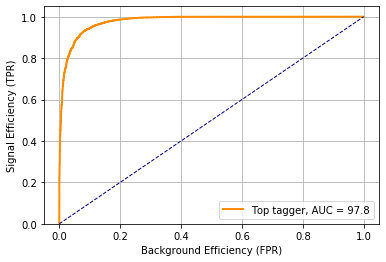

In [14]:
test = makeRoc(y_real, y_pred, ['Top'])